In [27]:
from cartopy import geodesic as geo
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
from scipy.optimize import minimize_scalar
import shapely
import pyproj

# geoid calculator
geoid = geo.Geodesic()

# See debug plots
debug_plots = False

# Solution for Blog Post 2020-12-01
Original post [is here](https://www.aerosci.dev/2020/12/01/left-right-side-of-line.html).

## Determining Which Side of a Geodesic a Point is On

Let there be a point on the continent of North America.

In [28]:
point_off_line_deg = (-82, 38) # (lon, lat)

And, let there be a line that does _not_ go through the point.

In [29]:
# define an arbitrary line on the ellipsoid with some reasonable length
start_point_deg = (-79.0, 36)
geodesic_length_m = 250.0 * 1852.0
course_ned_deg = 335
b = geoid.direct(start_point_deg, course_ned_deg, geodesic_length_m)
end_point_deg = np.array(b)
end_point_deg = (end_point_deg[0][0], end_point_deg[0][1])

Let's give ourselves a convencience function that does some plotting for us... :D

In [30]:
def create_figure(start_point_deg:tuple=None, end_point_deg:tuple=None, point_off_line_deg:tuple=None, closest_point_on_line_deg:tuple=None):
    fig_debug = go.Figure([
         go.Scattergeo(lat=[point_off_line_deg[1]], 
                       lon=[point_off_line_deg[0]], 
                       name='point_off_line'),
         go.Scattergeo(lat=[start_point_deg[1]], 
                       lon=[start_point_deg[0]], 
                       marker=dict(color='black'),
                       name='start_point'),
         go.Scattergeo(lat=[end_point_deg[1]], 
                       lon=[end_point_deg[0]], 
                       marker=dict(color='magenta'),
                       name='end_point'),
         go.Scattergeo(lat=[start_point_deg[1], end_point_deg[1]], 
                       lon=[start_point_deg[0], end_point_deg[0]], 
                       mode='lines',
                       name='line_on_ellipsoid')
    ])
    if closest_point_on_line_deg is not None:
        fig_debug.add_trace(go.Scattergeo(lat=[closest_point_on_line_deg[1]], 
                                          lon=[closest_point_on_line_deg[0]], 
                                          name='closest_point_on_line'))

    fig_debug.update_layout(geo=dict(scope='north america', lataxis_range=[30,45], lonaxis_range=[-90, -75]), height=400, width=600)
    
    return fig_debug

### Closest Point On Line Algorithm

First, find a point on the line that is nearest to `point_off_line`. There are many ways to do this; here, we use `scipy.optimize.minimize_scalar`.

In [31]:
distance_from_start_point_to_point_off_line_m = np.array(geoid.inverse(point_off_line_deg, start_point_deg))[0][0]
distance_from_end_point_to_point_off_line_m = np.array(geoid.inverse(point_off_line_deg, end_point_deg))[0][0]
y_intercept_shift = distance_from_start_point_to_point_off_line_m + (distance_from_end_point_to_point_off_line_m-distance_from_start_point_to_point_off_line_m)/2

if debug_plots:
    fig_debug = create_figure(start_point_deg=start_point_deg,
                              end_point_deg=end_point_deg,
                              point_off_line_deg=point_off_line_deg)
    
def distance_from_point_off_line(distance_from_start_point_m=0):
    b = geoid.direct(start_point_deg, course_ned_deg, distance_from_start_point_m)
    point_on_line_at_distance_deg = np.array(b)[0]
    c = geoid.inverse(point_off_line_deg, (point_on_line_at_distance_deg[0], point_on_line_at_distance_deg[1]))
    distance_from_point_off_line_m = np.array(c)[0][0]
    
    if debug_plots:
        fig_debug.add_trace(
            go.Scattergeo(lat=[point_on_line_at_distance_deg[1]], 
                       lon=[point_on_line_at_distance_deg[0]], 
                       mode='markers',
                       hovertext=f'y:{distance_from_point_off_line_m}',
                       name=f'x:{distance_from_start_point_m}')
        )
    
    return distance_from_point_off_line_m

def find_closest_point_on_line():
    # use bisection to find the closest point along the geodesic within a tolerance of 1 meters
    result = minimize_scalar(fun=distance_from_point_off_line, bounds=(0, geodesic_length_m), method='bounded', options={'xatol': 10, 'maxiter': 500, 'disp': 0})
    if not result.success:
        print(f'FAIL: {result.message}')
    distance_from_start_m = result.x
    
    # Calculate the lat/lon of this point
    b = geoid.direct(start_point_deg, course_ned_deg, distance_from_start_m)
    perpendicular_point_on_line_deg = (np.array(b)[0][0], np.array(b)[0][1])
    return perpendicular_point_on_line_deg

In [32]:
closest_point_on_line_deg = find_closest_point_on_line()
# print(closest_point_on_line_deg)

if debug_plots:
    fig_debug.show()

Let's visualize this solution of the nearest point on the line. The figure above (only visible if debug plotting is turned on) shows the solution to the `find_closest_point_on_line` algorithm. The figure below shows an example geometry of the kind that we're trying to solve algorithmically. We have a line starting at `start_point` and ending at `end_point`. The line has directionality, so a LEFT and RIGHT side. The point `point_off_line` is clearly to the LEFT of the line according to the implied directionality of the line. 


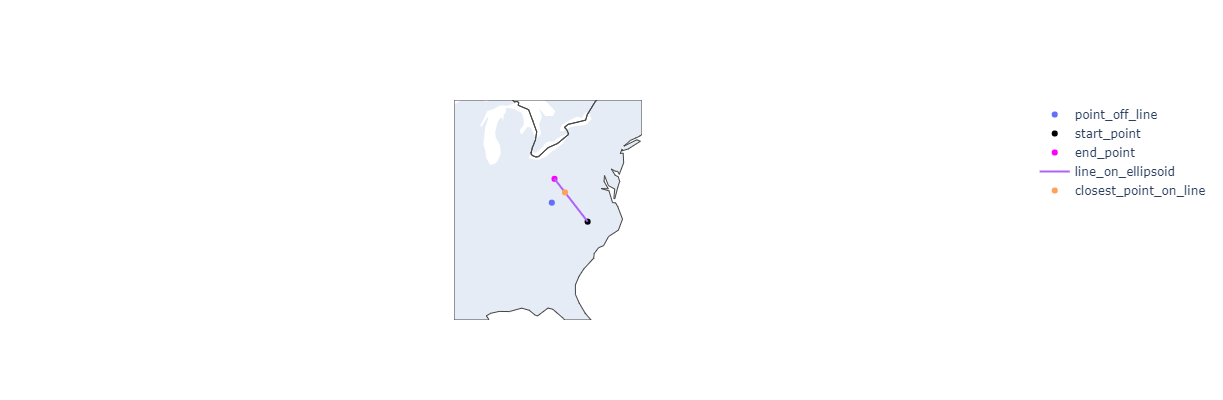

In [33]:
fig = create_figure(start_point_deg=start_point_deg, 
                    end_point_deg=end_point_deg,
                    point_off_line_deg=point_off_line_deg,
                    closest_point_on_line_deg=closest_point_on_line_deg)
fig.show()

### Side Of Line Algorithm

Looking at the last figure, we can ask the important question: to which side of the line is `point_off_line`? LEFT or RIGHT?

In [34]:
transformer = pyproj.Transformer.from_crs(
    {"proj":'latlong', "ellps":'WGS84', "datum":'WGS84'},
    {"proj":'geocent', "ellps":'WGS84', "datum":'WGS84'},
    )

def side_of_line(geodesic_crs_ned_deg=None, lat_lon_point_off_line_deg:tuple=None, closest_point_on_line_deg:tuple=None):
    c_vector = transformer.transform(lat_lon_point_off_line_deg[0], lat_lon_point_off_line_deg[1], 6378137, radians=False)
#     print(f'c_vector: {c_vector}')
    d_vector = transformer.transform(closest_point_on_line_deg[0], closest_point_on_line_deg[1], 6378137, radians=False)
#     print(f'd_vector: {d_vector}')
    v_vector = np.cross(c_vector, d_vector)
#     print(f'v_vector: {v_vector}')
    v_vector_unit = v_vector/np.linalg.norm(v_vector)
#     print(f'{v_vector_unit}')
    
    side_as_string = 'NONE'
    angular_tolerance_deg = 5
    is_westerly = abs(geodesic_crs_ned_deg-270) < angular_tolerance_deg
    is_easterly = abs(geodesic_crs_ned_deg-90) < angular_tolerance_deg
    if is_easterly:
        if v_vector_unit[0] > 0:
            side_as_string = 'LEFT'
        else:
            side_as_string = 'RIGHT'
    if is_westerly:
        if v_vector_unit[0] < 0:
            side_as_string = 'RIGHT'
        else:
            side_as_string = 'LEFT'
    if geodesic_crs_ned_deg < 90 or geodesic_crs_ned_deg > 270:
        if v_vector_unit[2] > 0:
            side_as_string = 'LEFT'
        else:
            side_as_string = 'RIGHT'
    if geodesic_crs_ned_deg > 90 and geodesic_crs_ned_deg < 270:
        if v_vector_unit[2] < 0:
            side_as_string = 'LEFT'
        else:
            side_as_string = 'RIGHT'

    return side_as_string

In [35]:
expected_side = 'LEFT'
point_is_on_side = side_of_line(geodesic_crs_ned_deg=course_ned_deg, 
                                lat_lon_point_off_line_deg=point_off_line_deg,
                                closest_point_on_line_deg=closest_point_on_line_deg)
print(f'The point is on the "{point_is_on_side}" side of the line; expected {expected_side}.')

The point is on the "LEFT" side of the line; expected LEFT.


In [36]:
# just in case debug plotting is turned on, turn it off for the rest of this notebook
debug_plots = False

----

Now that a single solution has been demonstrated, try some other geometries to make sure `side_of_line` is really working. Here we go!

## East Line

Let's try again with a line pointing east.

In [37]:
course_ned_deg = 90

In [38]:
start_point_deg = (-83.0, 37)
b = geoid.direct(start_point_deg, course_ned_deg, geodesic_length_m)
end_point_deg = np.array(b)[0]
end_point_deg = (end_point_deg[0], end_point_deg[1])
closest_point_on_line_deg = find_closest_point_on_line()
# print(closest_point_on_line_deg)

if debug_plots:
    fig_debug.show()

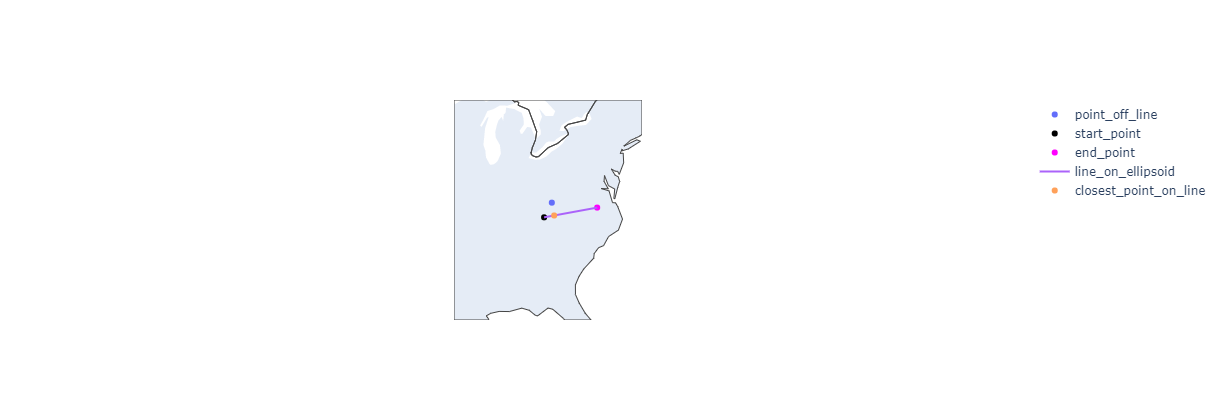

In [39]:
fig = create_figure(start_point_deg=start_point_deg, 
                    end_point_deg=end_point_deg,
                    point_off_line_deg=point_off_line_deg,
                    closest_point_on_line_deg=closest_point_on_line_deg)
fig.show()

In [40]:
expected_side = 'LEFT'
point_is_on_side = side_of_line(geodesic_crs_ned_deg=course_ned_deg, 
                                lat_lon_point_off_line_deg=point_off_line_deg,
                                closest_point_on_line_deg=closest_point_on_line_deg)
print(f'The point is on the "{point_is_on_side}" side of the line; expected {expected_side}.')

The point is on the "LEFT" side of the line; expected LEFT.


## West Line

And again with a line pointing west.

In [41]:
course_ned_deg = 269

In [42]:
start_point_deg = (-78, 37)
b = geoid.direct(start_point_deg, course_ned_deg, geodesic_length_m)
end_point_deg = np.array(b)[0]
end_point_deg = (end_point_deg[0], end_point_deg[1])
closest_point_on_line_deg = find_closest_point_on_line()
# print(closest_point_on_line_deg)

if debug_plots:
    fig_debug.show()

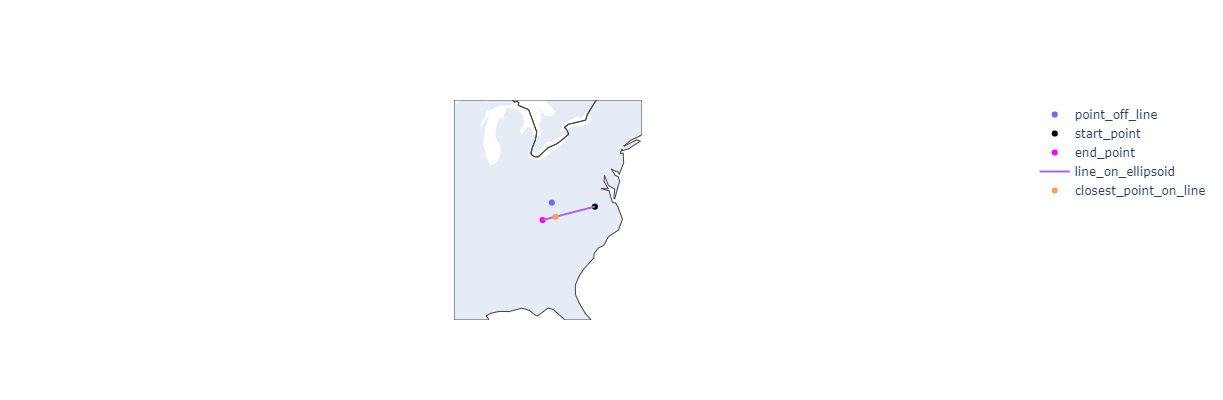

In [43]:
fig = create_figure(start_point_deg=start_point_deg, 
                    end_point_deg=end_point_deg,
                    point_off_line_deg=point_off_line_deg,
                    closest_point_on_line_deg=closest_point_on_line_deg)
fig.show()

In [44]:
expected_side = 'RIGHT'
point_is_on_side = side_of_line(geodesic_crs_ned_deg=course_ned_deg, 
                                lat_lon_point_off_line_deg=point_off_line_deg,
                                closest_point_on_line_deg=closest_point_on_line_deg)
print(f'The point is on the "{point_is_on_side}" side of the line; expected {expected_side}.')

The point is on the "RIGHT" side of the line; expected RIGHT.


## Geodesics in Other Directions

What about other quadrants? Starting with south-west...

In [45]:
course_ned_deg = 225

In [46]:
start_point_deg = (-77.0, 37)
b = geoid.direct(start_point_deg, course_ned_deg, geodesic_length_m)
end_point_deg = np.array(b)[0]
end_point_deg = (end_point_deg[0], end_point_deg[1])
closest_point_on_line_deg = find_closest_point_on_line()
# print(closest_point_on_line_deg)

if debug_plots:
    fig_debug.show()

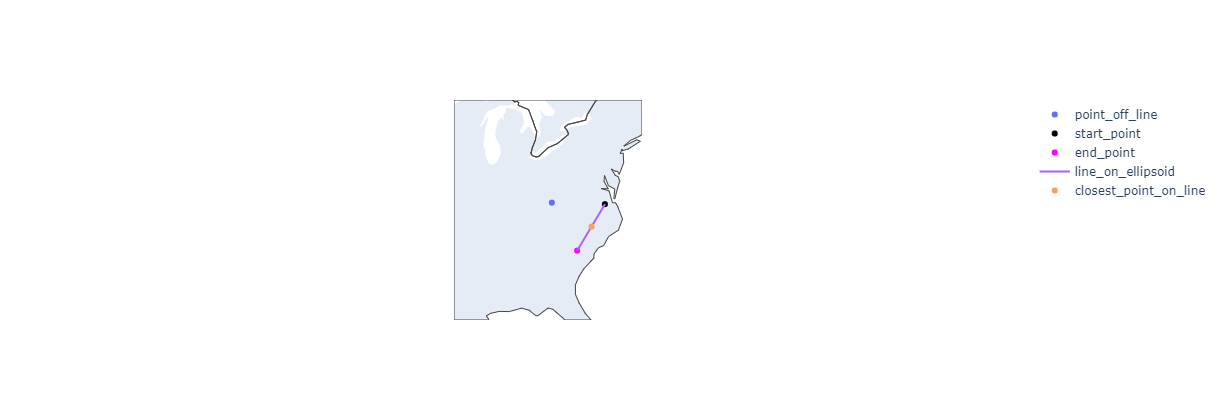

In [47]:
fig = create_figure(start_point_deg=start_point_deg, 
                    end_point_deg=end_point_deg,
                    point_off_line_deg=point_off_line_deg,
                    closest_point_on_line_deg=closest_point_on_line_deg)
fig.show()

In [48]:
expected_side = 'RIGHT'
point_is_on_side = side_of_line(geodesic_crs_ned_deg=course_ned_deg, 
                                lat_lon_point_off_line_deg=point_off_line_deg,
                                closest_point_on_line_deg=closest_point_on_line_deg)
print(f'The point is on the "{point_is_on_side}" side of the line; expected {expected_side}.')

The point is on the "RIGHT" side of the line; expected RIGHT.


And now let's do north-east...

In [49]:
course_ned_deg = 70

In [50]:
start_point_deg = (-85.0, 40)
b = geoid.direct(start_point_deg, course_ned_deg, geodesic_length_m)
end_point_deg = np.array(b)[0]
end_point_deg = (end_point_deg[0], end_point_deg[1])
closest_point_on_line_deg = find_closest_point_on_line()
# print(closest_point_on_line_deg)

if debug_plots:
    fig_debug.show()

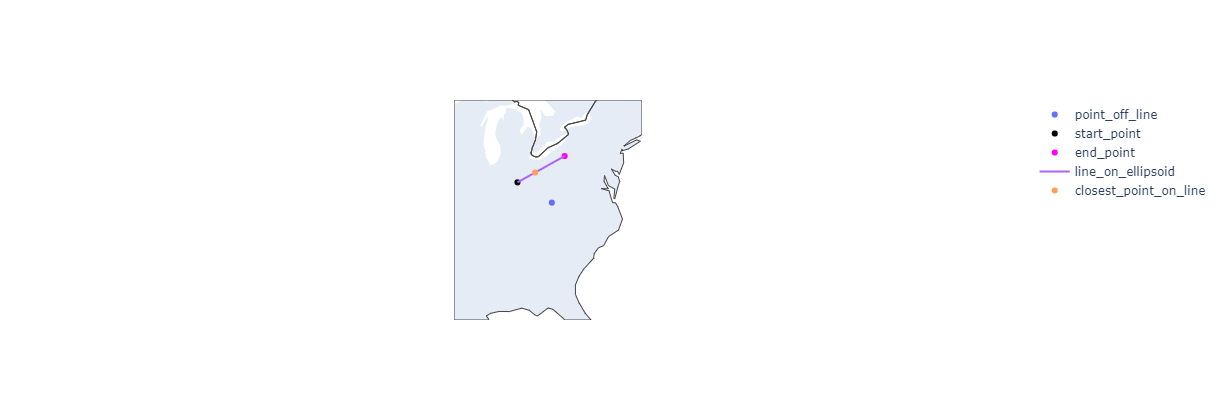

In [51]:
fig = create_figure(start_point_deg=start_point_deg, 
                    end_point_deg=end_point_deg,
                    point_off_line_deg=point_off_line_deg,
                    closest_point_on_line_deg=closest_point_on_line_deg)
fig.show()

In [52]:
expected_side = 'RIGHT'
point_is_on_side = side_of_line(geodesic_crs_ned_deg=course_ned_deg, 
                                lat_lon_point_off_line_deg=point_off_line_deg,
                                closest_point_on_line_deg=closest_point_on_line_deg)
print(f'The point is on the "{point_is_on_side}" side of the line; expected {expected_side}.')

The point is on the "RIGHT" side of the line; expected RIGHT.
